## Ensembles de Classificadores

Não seria exagero dizer que hoje em dia quase todo mundo utiliza alguma técnica de _ensemble_ para dados tabulares. Você provavelmente já ouviu falar em Random Forests, XGBoost, LightGBM, etc.

Um _ensemble_ é um grupo de classificadores que trabalha em conjunto. Há algumas formas de se criar um _ensemble_:

- Votação: classificadores independentes, vence o voto da maioria
- Bagging: classificadores treinados em visões diferentes dos dados, vence o voto da maioria ou a média
- Boosting: classificadores treinados sequencialmente para "corrigir" os erros dos classificadores anteriores

O scikit-learn fornece implementações de todos esse métodos. Vamos a cada um deles.

----------------------------------------------------------------------

### Votação

- Treinamos um conjunto qualquer de classificadores com os mesmos dados
- Todos os classificadores são treinados com todas as classes em um problema multi-classe
- Para uma nova observação, o classificador resultante pode:
    + atribuir a classe mais votada dentre todos os classificadores (hard voting)
    + atribuir a classe com maior valor a partir das somas das probabilidades (soft voting)


In [1]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = [15, 15]

from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import numpy as np

#define função para criar plots com fronteiras de decisão
def plot_decision_boundary(clf, X, y):
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = .02
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    
    Z = Z.reshape(xx.shape)
    plt.figure(1, figsize=(4, 3))
    plt.pcolormesh(xx, yy, Z, cmap=plt.cm.tab20)

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.tab20b, s=5)
    plt.axis('off')


#### Criação de dados de exemplo utilizando make_blobs (2 dimensões)

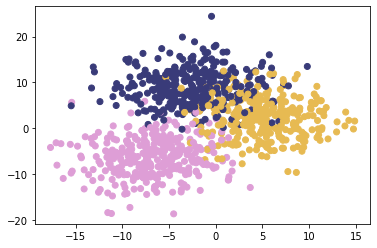

In [2]:
X, y = make_blobs(n_samples=1000, n_features=2, cluster_std=4, centers=3, random_state=42)
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.tab20b)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

#### Treinamento de um VotingClassifier com hard voting

In [3]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

classifiers = [('lr', LogisticRegression(solver='lbfgs', multi_class='auto')), 
               ('dt', DecisionTreeClassifier()),
               ('knn', KNeighborsClassifier())]

vch = VotingClassifier(classifiers, weights=[0.6, 0.3, 0.1], voting='hard')
%time vch.fit(X_train, y_train)
print(vch.score(X_test, y_test))

CPU times: user 14.6 ms, sys: 81 µs, total: 14.6 ms
Wall time: 15.1 ms
0.88


#### Treinamento de um VotingClassifier com soft voting

In [4]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

classifiers = [('lr', LogisticRegression(solver='lbfgs', multi_class='auto')), 
               ('dt', DecisionTreeClassifier()),
               ('knn', KNeighborsClassifier())]

vcs = VotingClassifier(classifiers, voting='soft')
%time vcs.fit(X_train, y_train)
print(vcs.score(X_test, y_test))

CPU times: user 21.3 ms, sys: 1.85 ms, total: 23.1 ms
Wall time: 21.6 ms
0.85


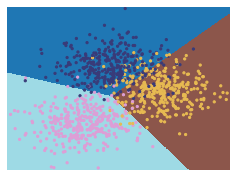

In [5]:
plot_decision_boundary(vch, X, y)

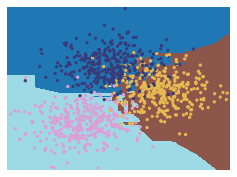

In [6]:
plot_decision_boundary(vcs, X, y)

----------------------------------------------------------------------

### Bagging (Bootstrap Aggregating)

- Treinamos múltiplas cópias de um mesmo classificador, cada um com visões diferentes dos dados
- Todos os classificadores são treinados com todas as classes em um problema multi-classe
- Para uma nova observação, o classificador resultante pode:
    + atribuir a classe mais votada dentre todos os classificadores (hard voting)
    + atribuir a classe com maior valor na média

#### O que significa "visões diferentes dos dados"?

Imagine que o seu dataset é uma amostra de um fenômeno real qualquer. É razoável assumir que, dependendo de quando ou de como a amostra foi feita, ela poderia ser um pouco diferente. Por exemplo, o ônibus das 14:15 raramente passa às 14:15 e zero segundos: sempre há uma pequena variação, mas podemos dizer que o ônibus que passa entre 14:14 e 14:18, por exemplo, é o ônibus das 14:15.

O bagging busca refletir essa variabilidade ao fornecer diferentes *amostras aleatórias* dos dados para cada classificador, e dessa forma ter vários classificadores ligeiramente diferentes, que no final, gerarão uma predição mais robusta.

Neste exemplo utilizaremos Árvores de Decisão como estimador (classificador) base. Quando fazemos isso, temos uma Random Forest.

In [8]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag10 = BaggingClassifier(DecisionTreeClassifier(), n_estimators=10)
%time bag10.fit(X_train, y_train)
print(bag10.score(X_test, y_test))

bag50 = BaggingClassifier(DecisionTreeClassifier(), n_estimators=50)
%time bag50.fit(X_train, y_train)
print(bag50.score(X_test, y_test))

CPU times: user 21.3 ms, sys: 0 ns, total: 21.3 ms
Wall time: 20.2 ms
0.835
CPU times: user 88.2 ms, sys: 1 µs, total: 88.2 ms
Wall time: 88.2 ms
0.84


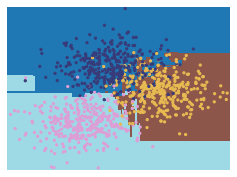

In [9]:
plot_decision_boundary(bag10, X, y)

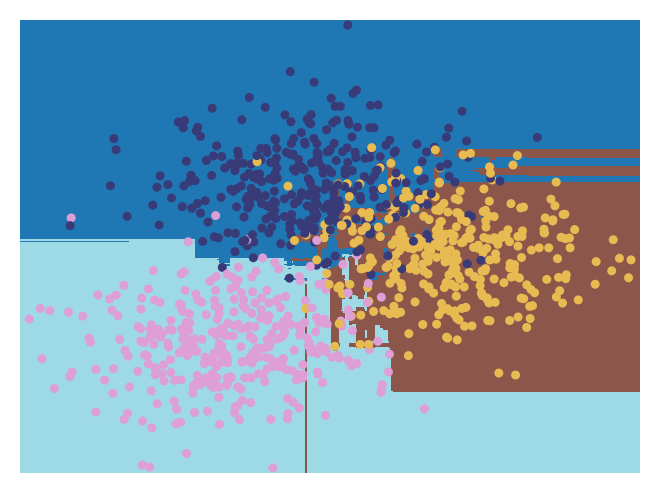

In [135]:
plot_decision_boundary(bag50, X, y)

----------------------------------------------------------------------

### Random Forests

Simplesmente Bagging com Árvores de decisão.

#### Por que usar árvores de decisão e não outro classificador qualquer, em particular, algum classificador mais sofisticado?

Porque árvores podem ser treinadas rapidamente, e apesar de não possuírem grande desempenho individualmente ("weak learners"), em grupo funcionam melhor do que um único classificador muito melhor.

In [10]:
from sklearn.ensemble import RandomForestClassifier

rf10 = RandomForestClassifier(n_estimators=10)
%time rf10.fit(X_train, y_train)
print(rf10.score(X_test, y_test))

rf50 = RandomForestClassifier(n_estimators=50)
%time rf50.fit(X_train, y_train)
print(rf50.score(X_test, y_test))

CPU times: user 29.1 ms, sys: 3.98 ms, total: 33.1 ms
Wall time: 31.8 ms
0.855
CPU times: user 71.9 ms, sys: 0 ns, total: 71.9 ms
Wall time: 71.8 ms
0.855


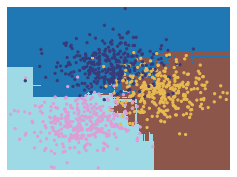

In [11]:
plot_decision_boundary(rf10, X, y)

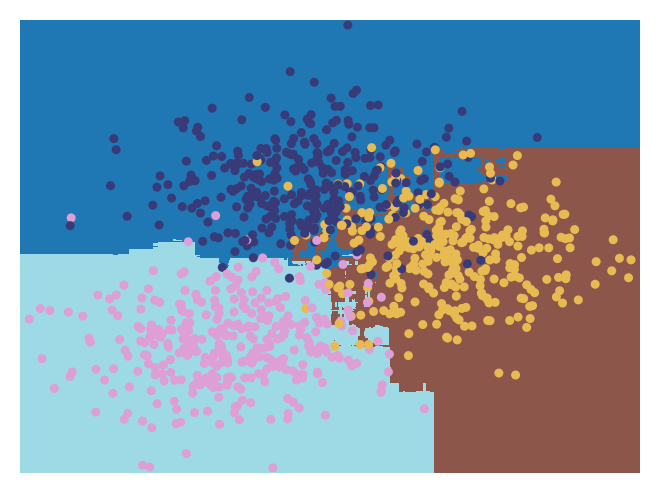

In [138]:
plot_decision_boundary(rf50, X, y)

----------------------------------------------------------------------

### Boosting

- Treinamos múltiplas cópias de um mesmo classificador sequencialmente, de modo que as observações em que o classificador anterior errou recebem peso maior para treinar o próximo classificador
- Cada classificador recebe um peso de acordo com o seu erro, de modo que classificadores que acertam mais possuem peso maior: $peso = ln((1-erro) / erro)$
- Para uma nova observação, o classificador resultante atribui a classe de acordo com a média ponderada de todos os classificadores


In [139]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

boost3 = AdaBoostClassifier(DecisionTreeClassifier(), n_estimators=3)
%time boost3.fit(X_train, y_train)
print(boost3.score(X_test, y_test))

boost20 = AdaBoostClassifier(DecisionTreeClassifier(), n_estimators=20)
%time boost20.fit(X_train, y_train)
print(boost20.score(X_test, y_test))

CPU times: user 4.34 ms, sys: 3 µs, total: 4.34 ms
Wall time: 3.62 ms
0.855
CPU times: user 3.69 ms, sys: 0 ns, total: 3.69 ms
Wall time: 3.63 ms
0.845


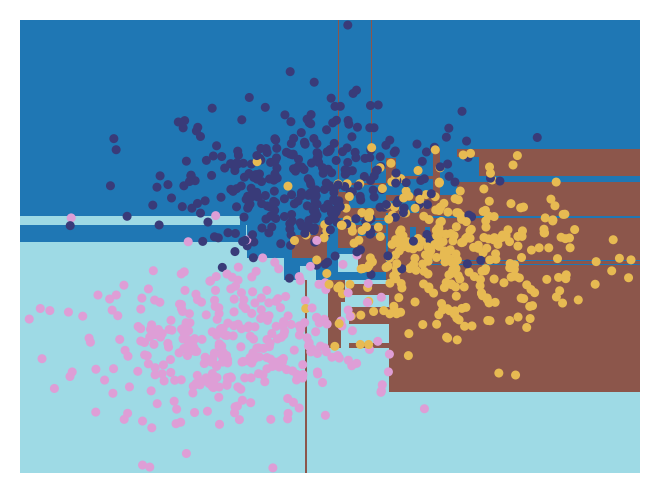

In [140]:
plot_decision_boundary(boost3, X, y)

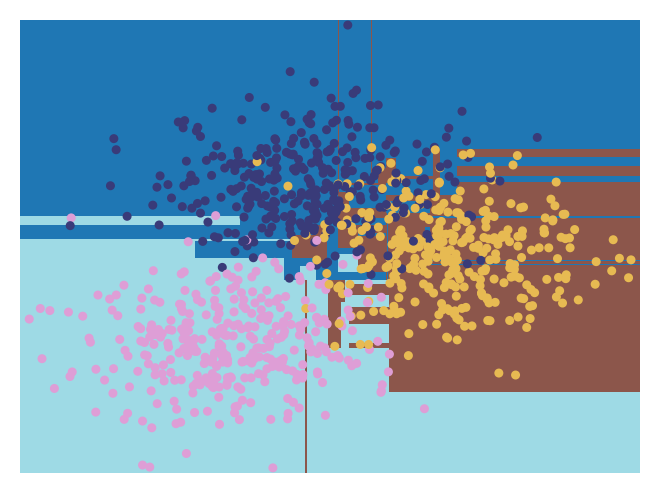

In [141]:
plot_decision_boundary(boost20, X, y)

----------------------------------------------------------------------

### Gradient Boosting

- Treinamos múltiplas cópias de um mesmo classificador sequencialmente, de modo que cada classificador seja treinado para:
    + reproduzir o erro do classificador anterior (residual)
    + reduzir o erro a cada novo classificador treinado (sentido inverso do gradiente do residual)

- Para uma nova observação, o classificador resultante atribui a classe de acordo com a soma dos erros produzidos por todos os classificadores treinados.


In [12]:
from sklearn.ensemble import GradientBoostingClassifier

gb3 = GradientBoostingClassifier(n_estimators=3)
%time gb3.fit(X_train, y_train)
print(gb3.score(X_test, y_test))

gb20 = GradientBoostingClassifier(n_estimators=20)
%time gb20.fit(X_train, y_train)
print(gb20.score(X_test, y_test))

CPU times: user 20.6 ms, sys: 5 µs, total: 20.6 ms
Wall time: 20.8 ms
0.88
CPU times: user 63 ms, sys: 5.24 ms, total: 68.2 ms
Wall time: 68.5 ms
0.86


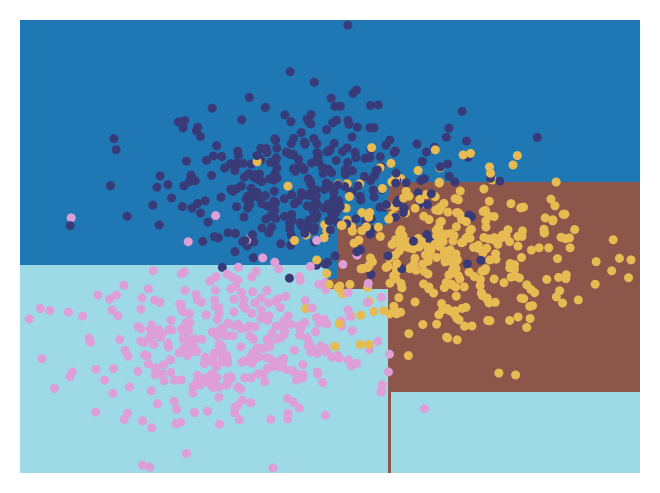

In [143]:
plot_decision_boundary(gb3, X, y)

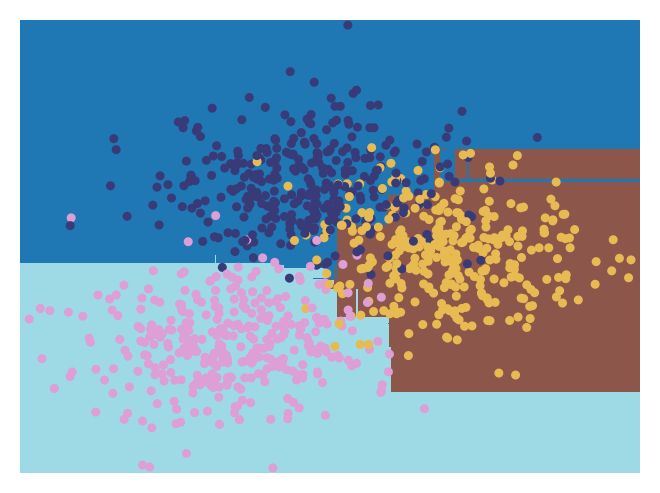

In [144]:
plot_decision_boundary(gb20, X, y)

----------------------------------------------------------------------

### eXtreme Gradient Boosting, ou XGBoost

In [13]:
from xgboost import XGBClassifier

xgb3 = XGBClassifier(n_estimators=3)
%time xgb3.fit(X_train, y_train)
print(xgb3.score(X_test, y_test))

xgb20 = XGBClassifier(n_estimators=20)
%time xgb20.fit(X_train, y_train)
print(xgb20.score(X_test, y_test))

CPU times: user 116 ms, sys: 64 ms, total: 180 ms
Wall time: 273 ms
0.88
CPU times: user 16.1 ms, sys: 4 ms, total: 20.1 ms
Wall time: 20 ms
0.87


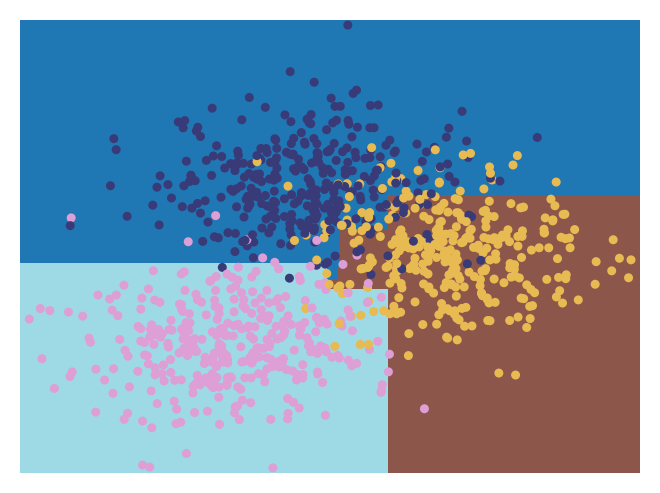

In [146]:
plot_decision_boundary(xgb3, X, y)

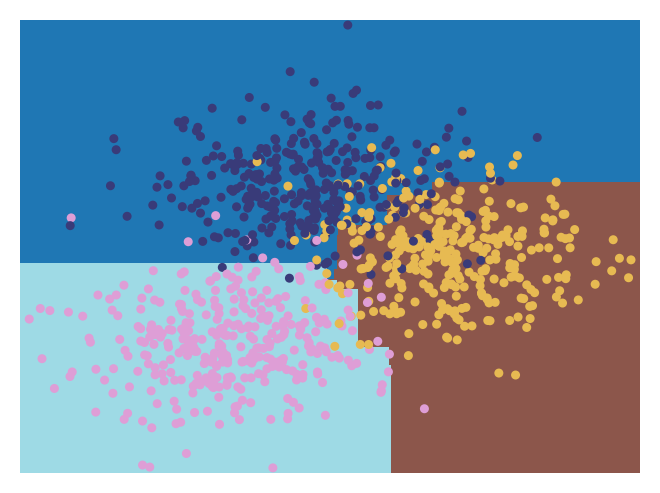

In [147]:
plot_decision_boundary(xgb20, X, y)